# AI61002_Spr2020
## Tutorial 3: Training MLP for Digit Recognition using Gradient Descent

In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

### Load data

In [2]:
apply_transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 256 # change according to system specs

trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

# Validation set with random rotations in the range [-90,90]
testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

In [3]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoader.dataset)))

No. of samples in train set: 60000
No. of samples in test set: 10000


### Define model architecture

In [4]:
class MLP(nn.Module):   # nn.Module --> Base class for all NN modules
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784,100)
        self.fc2 = nn.Linear(100,10)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x

In [7]:
use_gpu = torch.cuda.is_available()
net = MLP()
print(net)
if use_gpu:
    print('GPU is avaialble!')
    net = net.cuda()

MLP(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
GPU is avaialble!


### Train model

In [8]:
criterion = nn.CrossEntropyLoss() 
learning_rate = 0.1
num_epochs = 50

train_loss = []
train_acc = []
for epoch in range(num_epochs):
#     epochStartTime = time.time()
    
    running_loss = 0.0 
    running_corr = 0
        
    for i,data in enumerate(trainLoader):
        inputs,labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda() 
        # Initializing model gradients to zero
        net.zero_grad() 
        # Data feed-forward through the network
        outputs = net(inputs.view(inputs.shape[0],-1))
        # Predicted class is the one with maximum probability
        preds = torch.argmax(outputs,dim=1)
        # Finding the loss
        loss = criterion(outputs, labels) 
        # Accumulating the loss for each batch
        running_loss += loss 
        # Accumulate number of correct predictions
        running_corr += torch.sum(preds==labels)    
        
    totalLoss = running_loss/(i+1)
    # Calculating gradients
    totalLoss.backward()
    # Updating the model parameters
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)
        
    epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
    epoch_acc = running_corr.item()/60000
    
    
         
    train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
    train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph
       
        
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))              

Epoch 1/50 : Training loss: 2.3518 | Training Accuracy: 9.9467
Epoch 2/50 : Training loss: 2.3291 | Training Accuracy: 9.9933
Epoch 3/50 : Training loss: 2.3147 | Training Accuracy: 10.0967
Epoch 4/50 : Training loss: 2.3053 | Training Accuracy: 10.8633
Epoch 5/50 : Training loss: 2.2988 | Training Accuracy: 12.4817
Epoch 6/50 : Training loss: 2.2940 | Training Accuracy: 20.2933
Epoch 7/50 : Training loss: 2.2901 | Training Accuracy: 22.4783
Epoch 8/50 : Training loss: 2.2869 | Training Accuracy: 19.7083
Epoch 9/50 : Training loss: 2.2838 | Training Accuracy: 17.1400
Epoch 10/50 : Training loss: 2.2810 | Training Accuracy: 15.9967
Epoch 11/50 : Training loss: 2.2784 | Training Accuracy: 15.8950
Epoch 12/50 : Training loss: 2.2757 | Training Accuracy: 16.4500
Epoch 13/50 : Training loss: 2.2730 | Training Accuracy: 17.4100
Epoch 14/50 : Training loss: 2.2703 | Training Accuracy: 18.5283
Epoch 15/50 : Training loss: 2.2677 | Training Accuracy: 19.7983
Epoch 16/50 : Training loss: 2.2651 

Text(0,0.5,'Training')

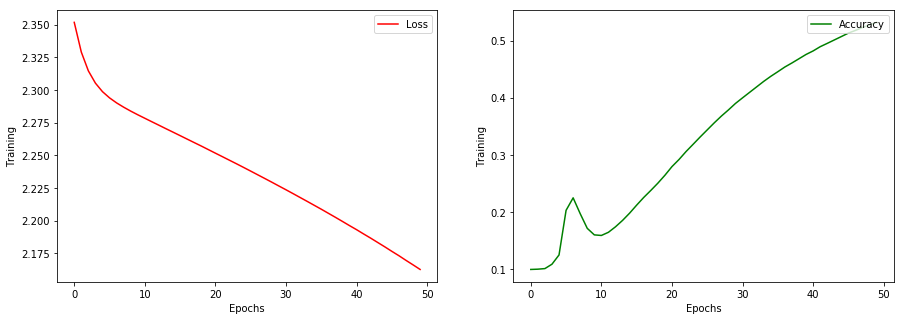

In [13]:
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs),train_loss,'r-',label='Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.subplot(122)
plt.plot(range(num_epochs),train_acc,'g-',label='Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

### Evaluation of trained model

In [14]:
correct_pred = 0
for data in testLoader:
    inputs,labels = data
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = net(inputs.view(inputs.shape[0],-1)) 
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)

test_accuracy = correct_pred.item()/10000.0
print('Testing accuracy = ',test_accuracy*100)

Testing accuracy =  55.02
